In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import shapely
import shapely.geometry

import sys

import SRRS
from SRRS import plotting,scoring,metrics

import glob
import os

# Comparing shrunk and un-shrunk gene/ontologies for BICCN

In [2]:
def jp(plot_df, title):
    """
    Plotting helper function
    """
    f = sns.jointplot(
        x = 'Full',
        y = 'Shrunk',
        kind = 'scatter',
        hue = 'sample_id',
        data = plot_df,
    )

    ax = f.ax_joint
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=3)
    ax.set_aspect('equal')
    
    f.fig.suptitle(title)
    f.fig.tight_layout()
    f.fig.subplots_adjust(top=0.9)

    return f,ax

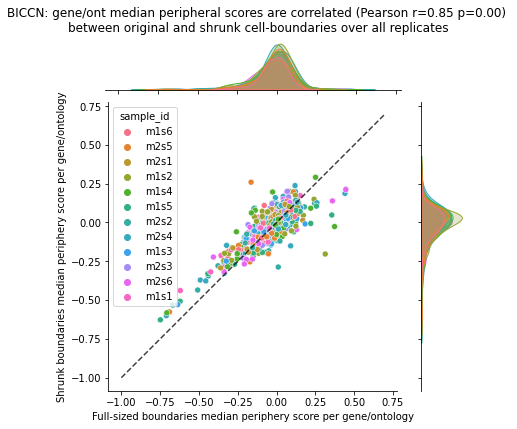

In [3]:
full_mop = pd.read_csv('../../outputs/gene_ontology/MOp_peripheral_ReadZs_gene_ontology.csv')
full_mop['Cell size'] = 'Full'

shrunk_mop = pd.read_csv('../../outputs/gene_ontology/MOp_shrunk_peripheral_ReadZs_gene_ontology.csv')
shrunk_mop['Cell size'] = 'Shrunk'

df = pd.concat((full_mop,shrunk_mop))

#Remove sample/gene/ontologies that aren't present in both shrunk and full sized
df = df.groupby(['sample_id','gene','ontology']).filter(lambda g: g['Cell size'].nunique() == 2)

piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_score',
).reset_index()

piv_df = piv_df.sample(1000) #note downsampling to reduce plot size

#plot
r,p = stats.pearsonr(piv_df['Full'], piv_df['Shrunk'])
title = (
"""BICCN: gene/ont median peripheral scores are correlated (Pearson r={:.2f} p={:.2f}) 
between original and shrunk cell-boundaries over all replicates""".format(r,p)
)
f,ax = jp(piv_df, title)
ax.set_xlabel('Full-sized boundaries median periphery score per gene/ontology')
ax.set_ylabel('Shrunk boundaries median periphery score per gene/ontology')
f.savefig('BICCN_periph_corr_between_orig_shrunk.svg')
plt.show(f)
plt.close()

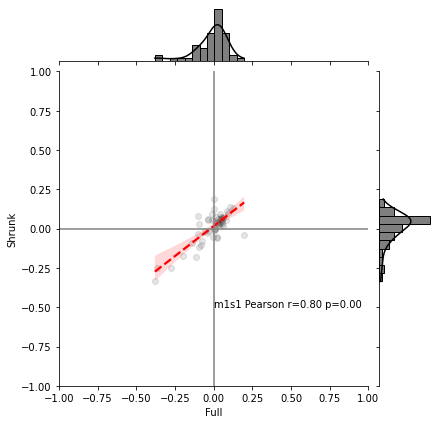

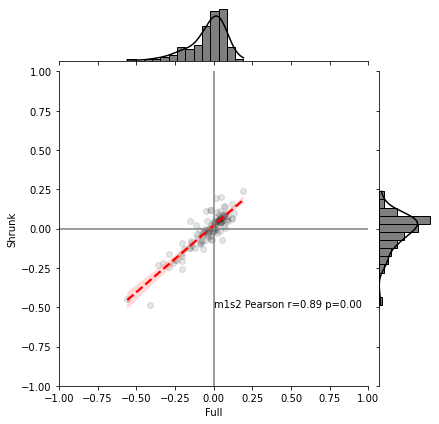

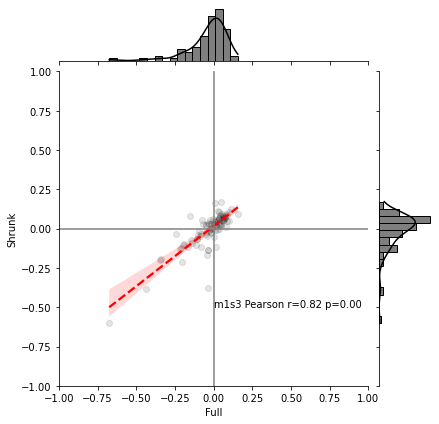

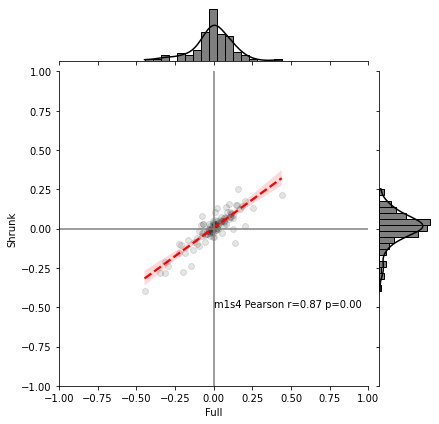

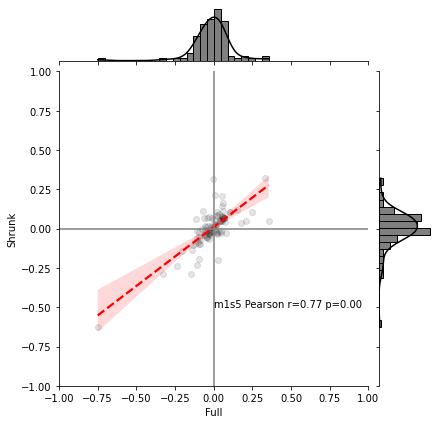

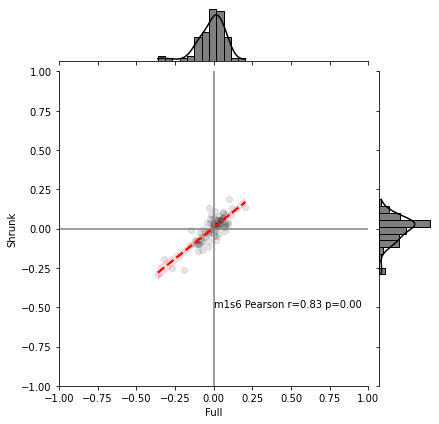

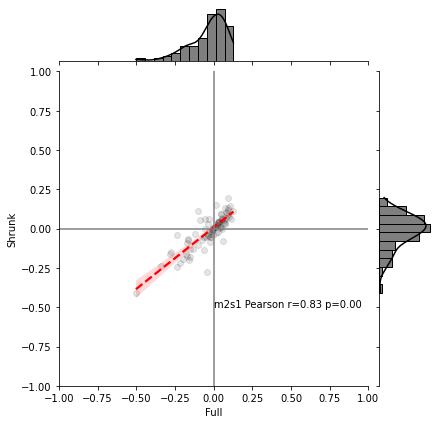

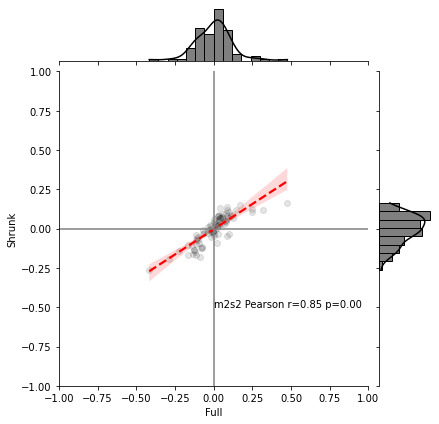

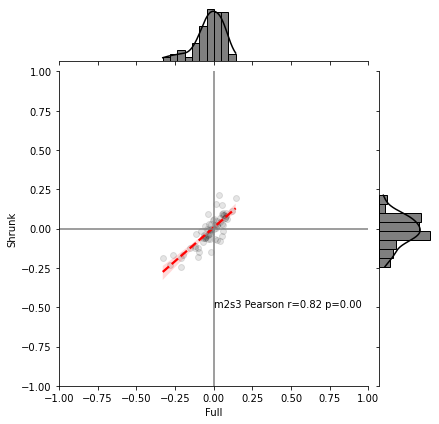

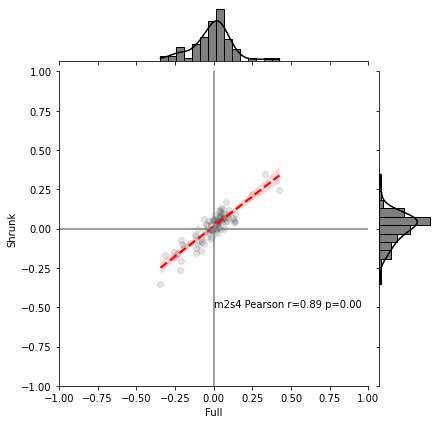

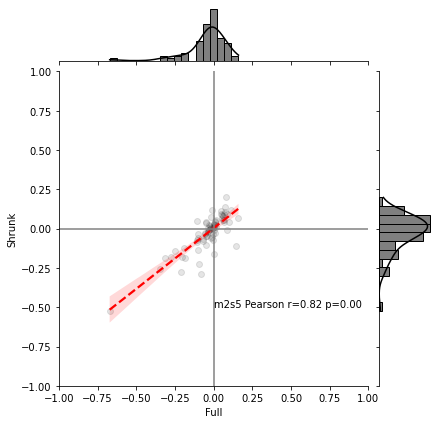

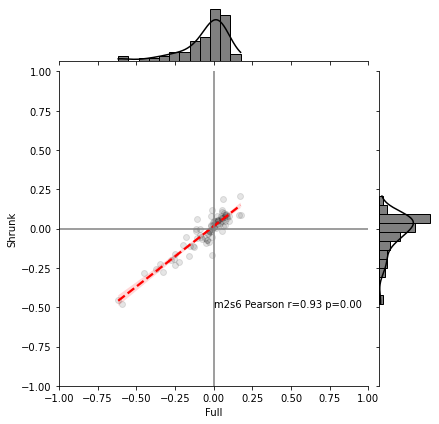

In [6]:
#Individual plots per BICCN sample
for i,(sample,g) in enumerate(piv_df.groupby('sample_id')):
    g = g.dropna()

    fig = sns.jointplot(
        x = 'Full',
        y = 'Shrunk',
        kind = 'reg',
        color = 'black',
        scatter_kws = {'alpha':0.1},
        line_kws = {'linestyle':'dashed','color':'red'},
        data = g,
    )
    r,p = stats.pearsonr(g['Full'], g['Shrunk'])
    
    fig.ax_joint.set_xlim(-1,1)
    fig.ax_joint.set_ylim(-1,1)
    fig.ax_joint.axhline(0,color='grey')
    fig.ax_joint.axvline(0,color='grey')
    fig.ax_joint.text(0,-0.5,'{} Pearson r={:.2f} p={:.2f}'.format(sample,r,p))
    plt.show()
    plt.close()



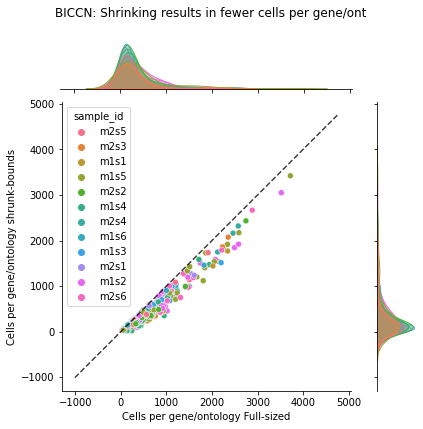

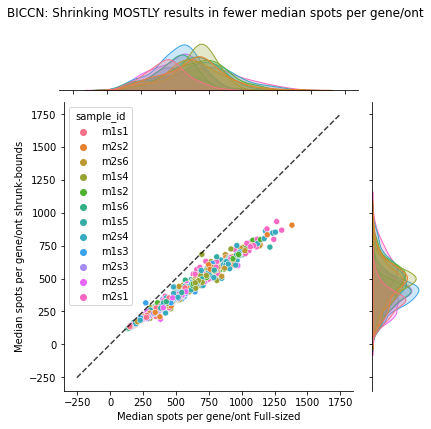


Reason why some gene/onts can have higher median spots 
is because low-count cells are filtered out, bringing the average up



In [5]:
#plot cell counts per gene/ont
cell_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='num_cells',
).reset_index()

cell_count_piv_df = cell_count_piv_df.sample(1000)

title = 'BICCN: Shrinking results in fewer cells per gene/ont'
f,ax = jp(cell_count_piv_df, title)
ax.set_xlabel('Cells per gene/ontology Full-sized')
ax.set_ylabel('Cells per gene/ontology shrunk-bounds')
f.savefig('BICCN_shrunk_gene_onts_fewer_cells.svg')
plt.show(f)
plt.close()

#plot median spot counts per gene/ont
spot_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_spots',
).reset_index()

spot_count_piv_df = spot_count_piv_df.sample(1000)

title = 'BICCN: Shrinking MOSTLY results in fewer median spots per gene/ont'
f,ax = jp(spot_count_piv_df, title)
ax.set_xlabel('Median spots per gene/ont Full-sized')
ax.set_ylabel('Median spots per gene/ont shrunk-bounds')
f.savefig('BICCN_shrunk_gene_onts_fewer_med_spots.svg')
plt.show(f)
plt.close()


print("""
Reason why some gene/onts can have higher median spots 
is because low-count cells are filtered out, bringing the average up
""")

# Comparing shrunk and un-shrunk gene/ontologies for Viz Brainmap

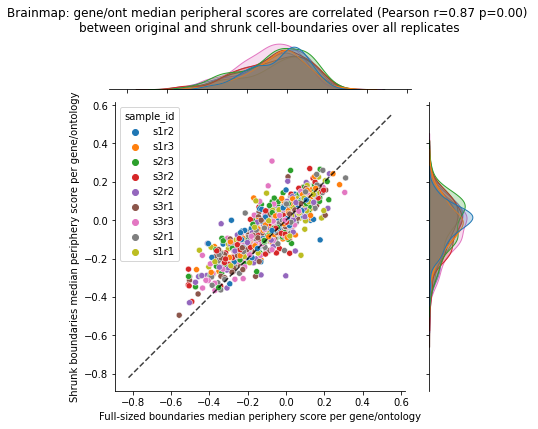

In [6]:
full_viz = pd.read_csv('../../outputs/gene_ontology/Vizgen_Brainmap_peripheral.csv')
full_viz['Cell size'] = 'Full'
full_viz['ontology'] = full_viz['annotation']

shrunk_viz = pd.read_csv('../../outputs/gene_ontology/Viz_shrunk_periph.csv')
shrunk_viz['Cell size'] = 'Shrunk'
shrunk_viz['sample_id'] = shrunk_viz['sample_id'].str.lower()

df = pd.concat((full_viz,shrunk_viz))

#Remove sample/gene/ontologies that aren't present in both shrunk and full sized
df = df.groupby(['sample_id','gene','ontology']).filter(lambda g: g['Cell size'].nunique() == 2)

piv_df = df.pivot( 
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_score',
).reset_index()

piv_df = piv_df.sample(1000) #note downsampling to reduce plot size
#plot
r,p = stats.pearsonr(piv_df['Full'], piv_df['Shrunk'])
title = (
"""Brainmap: gene/ont median peripheral scores are correlated (Pearson r={:.2f} p={:.2f}) 
between original and shrunk cell-boundaries over all replicates""".format(r,p)
)
f,ax = jp(piv_df, title)
ax.set_xlabel('Full-sized boundaries median periphery score per gene/ontology')
ax.set_ylabel('Shrunk boundaries median periphery score per gene/ontology')
f.savefig('Brainmap_periph_corr_between_orig_shrunk.svg')
plt.show(f)
plt.close()

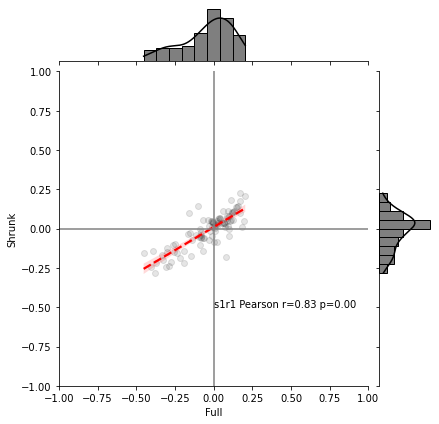

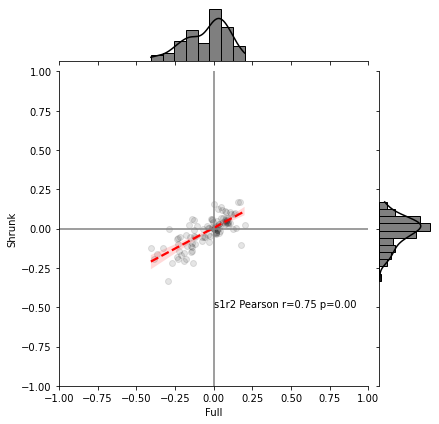

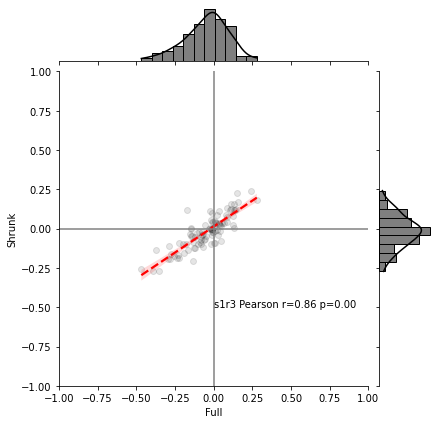

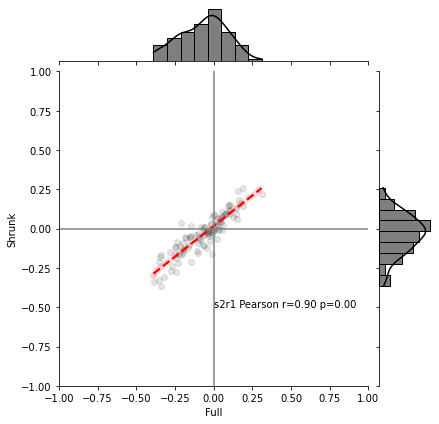

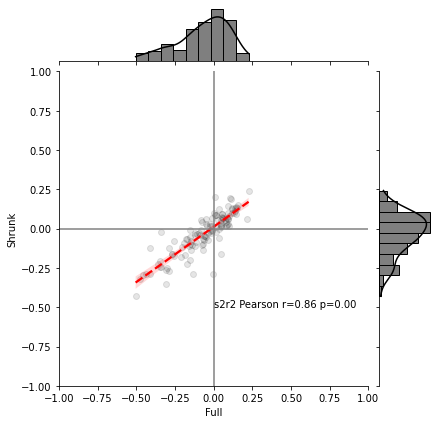

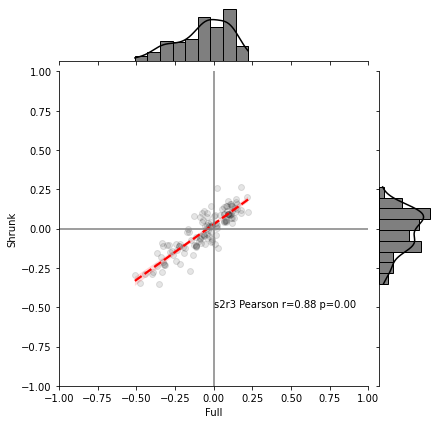

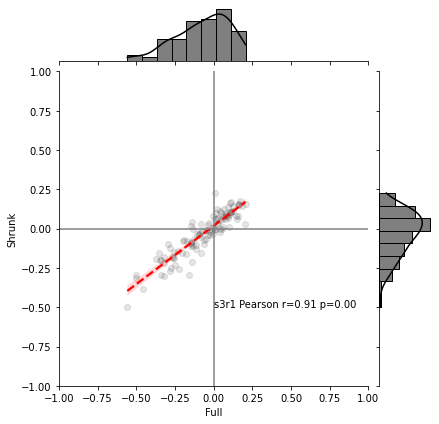

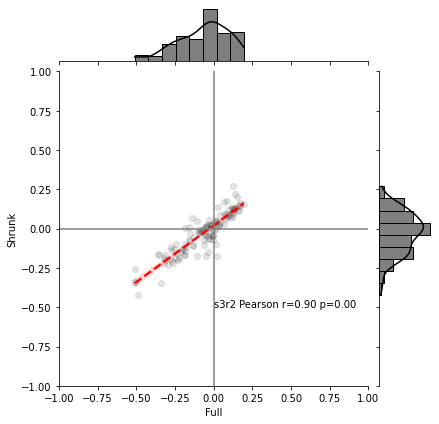

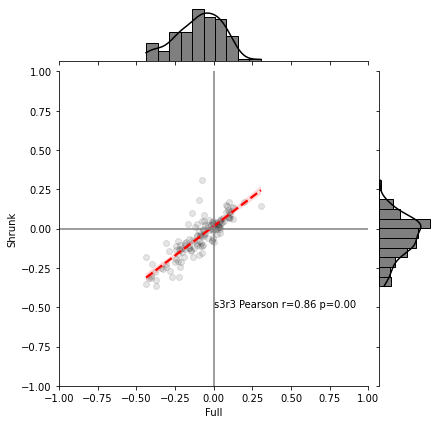

In [7]:
#breaking each sample into a separate plot
for i,(sample,g) in enumerate(piv_df.groupby('sample_id')):
    g = g.dropna()

    fig = sns.jointplot(
        x = 'Full',
        y = 'Shrunk',
        kind = 'reg',
        color = 'black',
        scatter_kws = {'alpha':0.1},
        line_kws = {'linestyle':'dashed','color':'red'},
        data = g,
    )
    r,p = stats.pearsonr(g['Full'], g['Shrunk'])
    
    fig.ax_joint.set_xlim(-1,1)
    fig.ax_joint.set_ylim(-1,1)
    fig.ax_joint.axhline(0,color='grey')
    fig.ax_joint.axvline(0,color='grey')
    fig.ax_joint.text(0,-0.5,'{} Pearson r={:.2f} p={:.2f}'.format(sample,r,p))
    plt.show()
    plt.close()

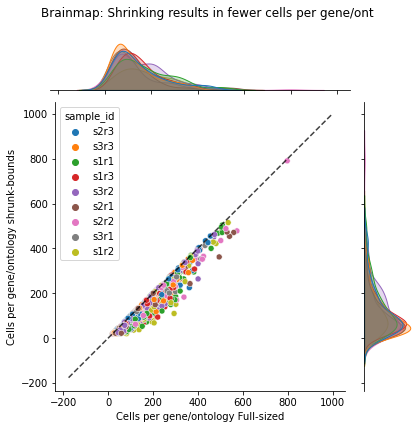

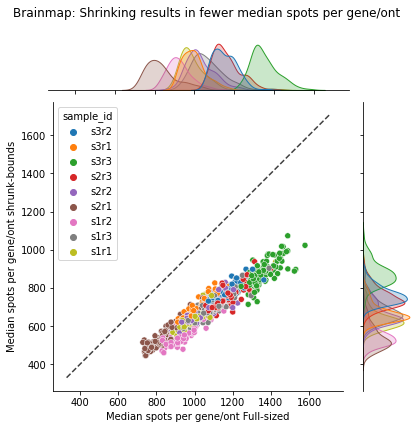

In [8]:
# Cells per gene/ontology plot
cell_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='num_cells',
).reset_index()

cell_count_piv_df = cell_count_piv_df.sample(1000)

title = 'Brainmap: Shrinking results in fewer cells per gene/ont'
f,ax = jp(cell_count_piv_df,title)
ax.set_xlabel('Cells per gene/ontology Full-sized')
ax.set_ylabel('Cells per gene/ontology shrunk-bounds')
f.savefig('Brainmap_shrunk_gene_onts_fewer_cells.svg')
plt.show(f)
plt.close()

# Median spots per gene/ontology plot
spot_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_spots',
).reset_index()

spot_count_piv_df = spot_count_piv_df.sample(1000)

title = 'Brainmap: Shrinking results in fewer median spots per gene/ont'
f,ax = jp(spot_count_piv_df, title)
ax.set_xlabel('Median spots per gene/ont Full-sized')
ax.set_ylabel('Median spots per gene/ont shrunk-bounds')
f.savefig('Brainmap_shrunk_gene_onts_fewer_med_spots.svg')
plt.show(f)
plt.close()

# Appendix

Creating the aggregate files that are used in read-in above

# Combining the shrunk per-sample files for Brainmap and BICCN

Creating a single file for the gene/cell data which I'll then aggregate to gene/ontology

In [13]:
vz_brainmap_paths = sorted(glob.glob('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/shrunk_cells/Slice*_periph.csv'))

#Vizgen Brainmap data
out_path = '../../outputs/gene_cell/Viz_shrunk_periph.csv'

for i,p in enumerate(vz_brainmap_paths):
    s,r = os.path.basename(p).split('_')[:2]
    s,r = s[-1],r[-1]
    print(s,r)
    
    df = pd.read_csv(p)
    df['mouse'] = 1
    df['sample'] = s
    df['replicate'] = r
    df['sample_id'] = 'S{}R{}'.format(s,r)
    
    df.to_csv(out_path, mode=('w' if i==0 else 'a'), header=i==0, index=False)
    

1 1
1 2
1 3
2 1
2 2
2 3
3 1
3 2
3 3


In [15]:
biccn_paths = sorted(glob.glob('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/shrunk_cells/mouse*_periph.csv'))

#BICCN MOp data
out_path = '../../outputs/gene_cell/MOp_shrunk_periph.csv'

for i,p in enumerate(biccn_paths):
    m,s = os.path.basename(p).split('_periph')[0].replace('mouse','').split('sample')
    print(m,s)
    
    df = pd.read_csv(p)
    df['mouse'] = int(m)
    df['sample'] = int(s)
    df['replicate'] = 1
    df['sample_id'] = 'm{}s{}'.format(m,s)
    
    df.to_csv(out_path, mode=('w' if i==0 else 'a'), header=i==0, index=False)
    

1 1
1 2
1 3
1 4
1 5
1 6
2 1
2 2
2 3
2 4
2 5
2 6
